This is HW6 for COM S 474, submitted by Aren Ashlock

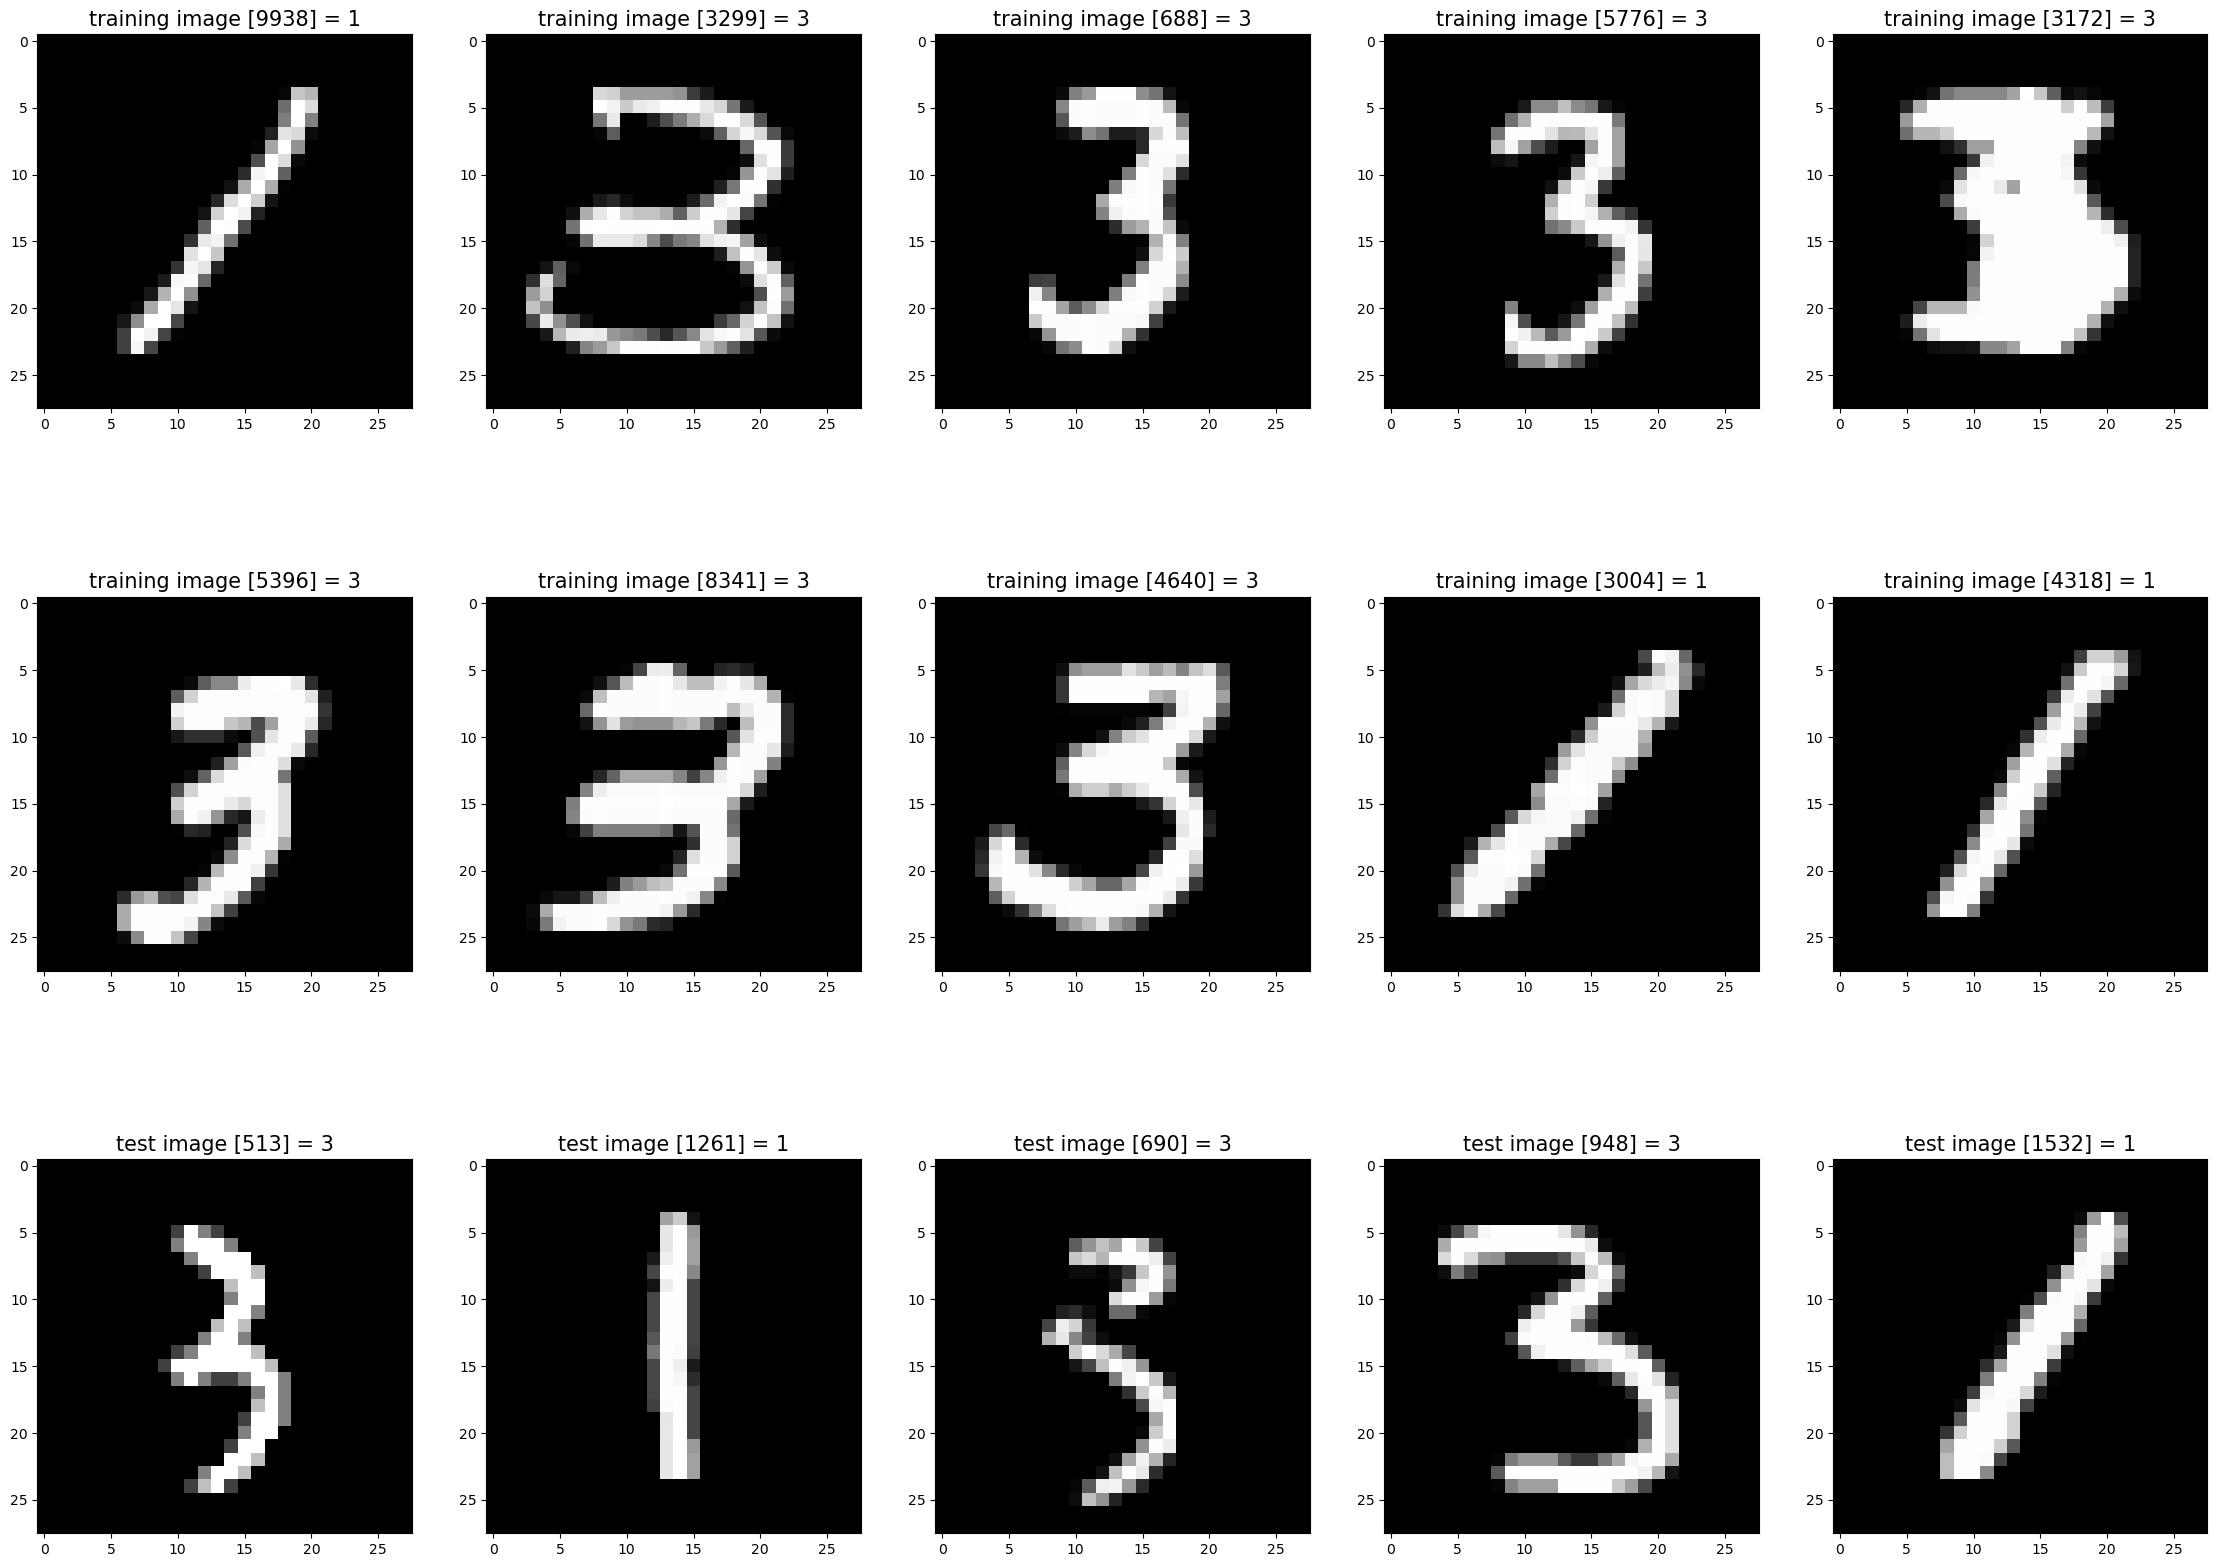

In [17]:
# -- Section 1: 1A --

from os.path  import join
import struct
from array import array
import numpy as np
import random
import matplotlib.pyplot as plt

class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        # arrays for making new dataset
        modifiedLabels = []
        modifiedImages = []
        
        # pick images with labels 1 and 3
        for i in range(size):
            if(labels[i] == 1):
                modifiedLabels.append(labels[i])
                modifiedImages.append(images[i])
            elif(labels[i] == 3):
                modifiedLabels.append(labels[i])
                modifiedImages.append(images[i])
        
        return modifiedImages, modifiedLabels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)  

# Set file paths based on added MNIST Datasets
training_images_filepath = 'data/mnist-dataset/train-images.idx3-ubyte'
training_labels_filepath = 'data/mnist-dataset/train-labels.idx1-ubyte'
test_images_filepath = 'data/mnist-dataset/t10k-images.idx3-ubyte'
test_labels_filepath = 'data/mnist-dataset/t10k-labels.idx1-ubyte'

# Load MINST dataset
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

# Show example images
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(28, 28))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

random_images = []
for i in range(0, 10):
    r = random.randint(1, 12873)
    random_images.append((x_train[r], 'training image [' + str(r) + '] = ' + str(y_train[r])))
for i in range(0, 5):
    r = random.randint(1, 2145)
    random_images.append((x_test[r], 'test image [' + str(r) + '] = ' + str(y_test[r])))

show_images(list(map(lambda x: x[0], random_images)), list(map(lambda x: x[1], random_images)))

In [18]:
# -- Section 1: General Tensors and DataLoader for B-D --

import torch
from torch.utils.data import TensorDataset, DataLoader

# Convert data to PyTorch tensors
train_images_tensor = torch.tensor(x_train, dtype=torch.float) / 255.0  # Normalize
train_labels_tensor = torch.tensor(y_train, dtype=torch.long)
test_images_tensor = torch.tensor(x_test, dtype=torch.float) / 255.0  # Normalize
test_labels_tensor = torch.tensor(y_test, dtype=torch.long)

# Create TensorDatasets
train_dataset = TensorDataset(train_images_tensor.unsqueeze(1), train_labels_tensor)  # Add channel dimension
test_dataset = TensorDataset(test_images_tensor.unsqueeze(1), test_labels_tensor)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

In [19]:
# -- Section 1: 1B --

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Define a simple CNN
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.dropout = nn.Dropout()
        self.fc1 = nn.Linear(1024, 128) # After flattening the conv layers, adjust the size accordingly
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 1024) # Flatten the tensor for the fully connected layer
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
model = Net().to(device)


loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Training loop (removed 'for' loop since there is only 1 epoch)
for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    output = model(data)
    loss = loss_fn(output, target)
    loss.backward()
    optimizer.step()

# Testing loop - Calculate accuracy
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Accuracy of the CNN model on the test images: {accuracy * 100:.2f}%')

Accuracy of the CNN model on the test images: 100.00%


In [20]:
# -- Section 1: 1C --

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class SmallResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(SmallResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.linear = nn.Linear(128*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

model = SmallResNet(BasicBlock, [2, 2])

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

model = model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Training loop (removed 'for' loop since there is only 1 epoch)
for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    output = model(data)
    loss = loss_fn(output, target)
    loss.backward()
    optimizer.step()

# Testing loop - Calculate accuracy
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Accuracy of the ResNet model on the test images: {accuracy * 100:.2f}%')

Accuracy of the ResNet model on the test images: 99.67%


In [21]:
# -- Section 1: 1D --

import torch.nn as nn
import torch.optim as optim

# Assuming train_loader and test_loader are defined elsewhere

# Define a simple MLP
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 10)  # 10 classes for MNIST digits
)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training loop (removed 'for' loop since there is only 1 epoch)
for images, labels in train_loader:
    optimizer.zero_grad()
    output = model(images)
    loss = loss_fn(output, labels)
    loss.backward()
    optimizer.step()

# Testing loop - Calculate accuracy
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        output = model(images)
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Accuracy of the Feedforward NN model on the test images: {accuracy * 100:.2f}%')

Accuracy of the Feedforward NN model on the test images: 99.39%


-- Section 2 --

1)
    a) Parameters = (kernel height x kernel width x # of input channels + bias) x (# of kernels)<br>
       Parameters = (5 x 5 x 3 + 1) x 10<br>
       Parameters = 76 x 10<br>
       **Parameters = 760**<br>
    b) In order for the model to remain functional and compatible, the output of each channel must be at least be 
       1x1. Therefore, since there is no padding and the kernel size is 5x5, the **minimum size of the image must 
       be 5x5.**

2) ResNet aims to fix the issue "Gradiant Vanishing" which happens due to a network being too large to the point where the gradiant is close to 0 and it stops learning. This is caused by the back propagation property.

3) Dropout is a solution for addressing overfitting. Overfit makes it so that, at some point, the results actually get worse, so dropout gets rid of some of the units to prevent this.